# Digit Classification

This notebooks demonstrates common machine learning algorithms by applying them to digit classification problem. It uses the mnist data which is a large dataset of handwritten digits. These digits have been size normalized and centered in a 28x28 grid, making this dataset ready to be used with little or no pre processing.

More information about this dataset can be found here:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

### Get required libraries

In [1]:
# Suppress opening a new window for each plot.
%matplotlib inline 

import time
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib.ticker import MultipleLocator
# from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
import random
import pandas as pd
import sklearn.metrics as metrics

### Fetch mnist data

Let's first get the data. fetch_openml function in the sklearn package provides an easy way to download datasets from www.openml.org

In [2]:
X, Y = fetch_openml('mnist_784', version=1, return_X_y=True) 

In [3]:
# check shape of data
print ('data shape: ', X.shape)
print ('label shape:', Y.shape)

data shape:  (70000, 784)
label shape: (70000,)


### Divide data into train, test and dev data sets.

In [4]:
# Set the randomizer seed so results are the same each time.
np.random.seed(0)

# Rescale grayscale values to [0,1]. This is the only pre processing we'll do on this dataset!
X = X / 255.0

# Shuffle the input.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]


# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]

# Creating a mini training set to get quick initial analysis for computationally heavy algorithms
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

## Visualization
Now that we have the data, let us visualize it. Each row is is 784 features, each feature representing a pixel in a 28 by 28 grid. In the code below, each row is reshaped into a 28 by 28 grid and displayed using imshow function of matplotlib. 

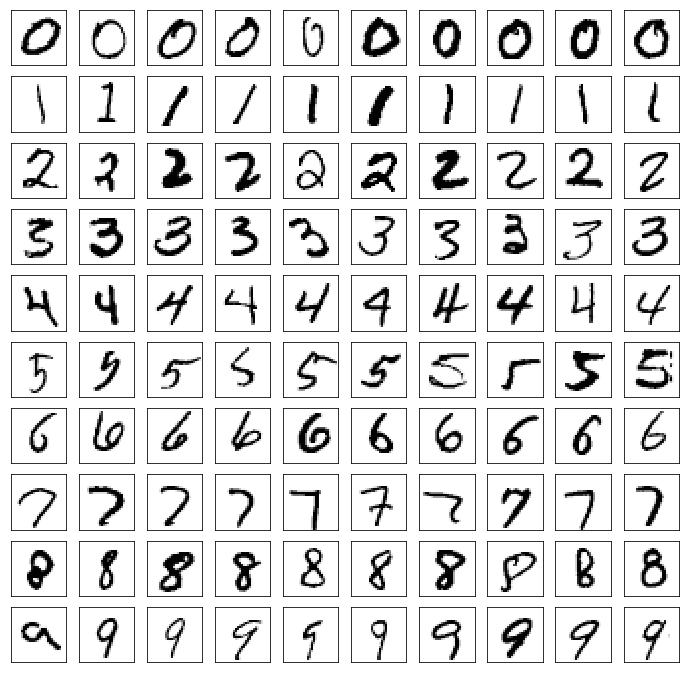

In [5]:
def visualize(num_examples=10):

    def getFig(digit, examples):
        XTemp = X[Y==digit]
        sample = random.sample(range(len(XTemp)),examples)
        return XTemp[sample]
    
    plt.figure(figsize=(12, 12))
    
    for number in range(10):
        examples = getFig(str(number), num_examples)
        col=0
        for example in examples:
            ax=plt.subplot2grid((10,num_examples), (number,col))
            ax.imshow(example.reshape(28,28), "Greys")
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)
            col+=1

visualize(10)

### KNN 

K Nearest Neighbors is one of the simplest classification algorithms. It predicts a class based on, well, its nearest neighbors. KNN, by default, uses Euclidean distance. See my blog for a discussion on distance in machine learning: https://medium.com/@vivekagarwal_75550/measuring-similarity-in-machine-learning-507a8cc18679?source=friends_link&sk=c387a451df386cb703eb8e164f5d1da6

In [6]:
def KNN(k_values):

    report=pd.DataFrame(index=k_values, columns = range(10))

    #Define a function to calculate accuracy given a confusion matrix
    def getAccuracy(cm):
        accurate_prediction=0
        for i in range(cm.shape[0]):
            accurate_prediction+=cm[i,i]
        accuracy = accurate_prediction/np.sum(cm)
        return accuracy

    def getPrecision(cm, i):
        return (cm[i,i]/sum(cm[:,i]))

    def getRecall(cm, i):
        return (cm[i,i]/sum(cm[i,]))

    def getF1Score(cm):
        f1=np.empty(cm.shape[0])
        for i in range(cm.shape[0]):
            precision = getPrecision(cm, i)
            recall = getRecall(cm, i)
            f1[i]=(2*recall*precision)/(precision + recall)
        return f1
    
    for k in k_values:
        classifier = KNeighborsClassifier(n_neighbors=k)
        trained_classifier = classifier.fit(mini_train_data, mini_train_labels)
        y_predict = trained_classifier.predict(dev_data)
        cm=confusion_matrix(dev_labels, y_predict)
        accuracy =  getAccuracy(cm)
        report.loc[k] = np.round(getF1Score(cm),2)
        print('For k='+str(k) +', accuracy is '+ str(accuracy))
        if k==1:
            rep = classification_report(dev_labels, y_predict)
    print('Here are Precision, Recall and f1 score for K=1')
    print(rep)
    print('')
    print('Here are f1 scores for various values of k')
    print(report)

k_values = [1, 3, 5, 7, 9]
KNN(k_values)

For k=1, accuracy is 0.884
For k=3, accuracy is 0.876
For k=5, accuracy is 0.882
For k=7, accuracy is 0.877
For k=9, accuracy is 0.875
Here are Precision, Recall and f1 score for K=1
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       106
           1       0.89      0.98      0.93       118
           2       0.90      0.79      0.84       106
           3       0.93      0.87      0.90        97
           4       0.91      0.85      0.88        92
           5       0.86      0.88      0.87        88
           6       0.92      0.92      0.92       102
           7       0.85      0.94      0.89       102
           8       0.83      0.77      0.80        94
           9       0.80      0.86      0.83        95

   micro avg       0.88      0.88      0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000


Here are f1 scores for various values of k
      0     1 

**Key takeaways:**

1. Digit 8 seems like the most difficult to train:  
    a. For various values of k, 8 consistently shows lowest f1 score. From the detailed classification report when k=1, we see the recall for digits 8 is only .78 which is quite low as compared to other digits. Which means if 8 is shown to the algorithm, one would expect them to be identified correctly only 78% of times based on the classification report above.

    b. One point to note is that the digit 8 also had lower sample size compared to some of the other digits. KNN is less likely to predict a less frequent class so there could be some bias in play as well.  
        
2. KNN is not exactly blazing fast. In fact, there is not much of a learning phase. At predict time, the algorithm finds distance of the test data row with all training data sets, finds the k nearest neighbors and predicts the class of majority of neighbors. 

### Impact of training size

In the previous example we used 1000 samples. Let us see how changing the number of training samples impacts accuracy and time taken to predict.

In [7]:
def trainSize(train_sizes, accuracies):
    
    def getTrainData(size):
        np.random.seed(1)
        shuffle = np.random.permutation(np.arange(X.shape[0]))[0:size]
        train_data, train_label = X[shuffle], Y[shuffle]
        return train_data, train_label
    
    def getAccuracy(cm):
        accurate_prediction=0
        for i in range(cm.shape[0]):
            accurate_prediction+=cm[i,i]
        accuracy = accurate_prediction/sum(sum(cm))
        return accuracy
    
    k=1
    classifier = KNeighborsClassifier(n_neighbors=k)
    for size in train_sizes:
        train_data, train_labels = getTrainData(size)
        start_time = time.time()
        trained_classifier = classifier.fit(train_data, train_labels)
        y_predict = trained_classifier.predict(dev_data)
        end_time = time.time()
        cm=confusion_matrix(dev_labels, y_predict)
        accuracy = getAccuracy(cm)
        accuracies.append([accuracy, round((end_time-start_time),3)])
        
    accuraciesDf = pd.DataFrame(accuracies)
    
    plt.figure(figsize=(8, 6))

    ax=plt.subplot2grid((1,2), (0,0))
    ax.plot(train_sizes, accuraciesDf[0])
    ax.set_xlabel("Size of training data")
    ax.set_ylabel("Accuracy")
    ax.set_title("Accuracy by training size")

    ax=plt.subplot2grid((1,2), (0,1))
    ax.plot(train_sizes, accuraciesDf[1])
    ax.set_xlabel("Size of training data")
    ax.set_ylabel("Time take to train and fit")
    ax.set_title("Time by training size")

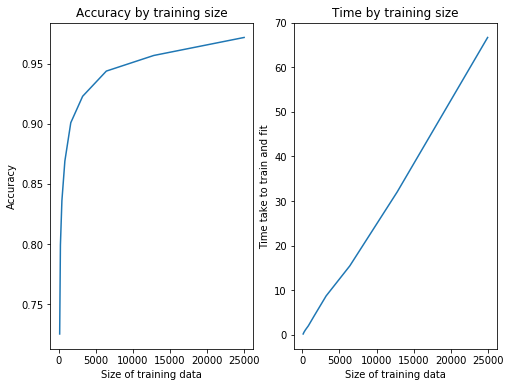

In [8]:
train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
trainSize(train_sizes, accuracies)

**Key takeaways:**

Improvement in accuracy is very slow after around 10000 samples. Time taken to predict however is linearly increasing with training size. Hence:
1. When using KNN, trying to source large amounts of data is unlikely to provide good return on investment.
2. When dealing with massive amounts of data, KNN might not be a good choice as it doesn't seem to scale very well.


### Most confused pair

Finding which digit pairs are most confused with each other

[[101   0   1   0   0   0   1   1   2   0]
 [  0 116   1   0   0   0   0   0   1   0]
 [  1   4  84   2   2   0   2   4   6   1]
 [  0   2   0  84   0   6   0   2   3   0]
 [  0   0   1   0  78   0   0   2   0  11]
 [  2   0   0   1   1  77   5   0   2   0]
 [  1   2   1   0   1   2  94   0   1   0]
 [  0   1   1   0   0   0   0  96   0   4]
 [  1   5   4   3   1   3   0   1  72   4]
 [  0   1   0   0   3   2   0   7   0  82]]

Most confused pair is  [4, 9] . They have been confused with each other  14  times.

Here are the mistakes:


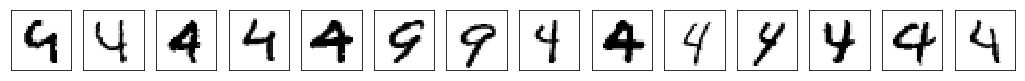

In [ ]:
def confusedPair():

    k=1
    classifier = KNeighborsClassifier(n_neighbors=k)
    trained_classifier = classifier.fit(mini_train_data, mini_train_labels)
    y_predict = trained_classifier.predict(dev_data)
    cm=confusion_matrix(dev_labels, y_predict)
    print(cm)
    
    #finding the most confused pair
    most_confused_pair=[-1,-1]
    max_confusion = 0
    for digit1 in range(10):
        for digit2 in range(digit1+1,10):
            confusion = cm[digit1, digit2] + cm[digit2, digit1]
            if confusion>max_confusion:
                most_confused_pair=[digit1,digit2]
                max_confusion = confusion
    print()
    print('Most confused pair is ', most_confused_pair, '. They have been confused with each other ', max_confusion, ' times.')
    print()
    print("Here are the mistakes:")

    #printing most confused pairs

    def getFig(digits):
        XTemp = dev_data[((dev_labels==str(digits[0])) & (y_predict==str(digits[1])))|((dev_labels==str(digits[1])) & (y_predict==str(digits[0])))]
        return XTemp

    examples = getFig(most_confused_pair)
    num_examples= len(examples)

    plt.figure(figsize=(18, 2))

    for col in range(num_examples):
        ax=plt.subplot2grid((1,num_examples), (0,col))
        ax.imshow(examples[col].reshape(28,28), "Greys")
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

confusedPair()

### Blurring for clarity

A common image processing technique is to smooth an image by blurring. This is analogous to smoothing a line where a point is adjusted based on values of points near it. For example a moving average replaces a value in a time series by an average over a predefined period. Similarly blurring averages a pixel brightness based on pixels around it.

While more complex blurring funcions are available, to demonstrate the concept a a simplified Gaussian blur is implemented by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Then we will apply the this blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

In [ ]:
def blurring():
    
    def simpleBlur(digit, row=28, col=28):
        weight = 2
        grid = np.copy(digit).reshape(row,col)
        for i in range(row):
            for j in range(col):
                #get neighboring 8 cells + itself. Using min, max to avoid going out of grid
                neighbor = digit.reshape(row,col)[max(0,i-1):min(row,i+2), max(0,j-1):min(col, j+2)] 
                #divide by count of cells adjusted for weight to retain the [0,1] scaling.
                grid[i,j] = (sum(sum(neighbor)) + (weight - 1)*grid[i,j])/(neighbor.size+weight-1)
        ret = grid.reshape(-1, row*col)
        return(ret)

    def runKNN(X,Y,tX, tY, k=1):
        classifier = KNeighborsClassifier(n_neighbors=k)
        trained_classifier = classifier.fit(X, Y)
        y_predict = trained_classifier.predict(tX)
        rep = classification_report(tY, y_predict)
        return rep
    
    X=mini_train_data
    Y=mini_train_labels
    
#preprocess the training data but not the dev data
    XBlur = np.empty((0,X.shape[1]))
    for i in range(X.shape[0]):
        XBlur=np.vstack([XBlur, simpleBlur(X[i])])
    
    rep = runKNN(XBlur,Y, dev_data, dev_labels)
    print("Training data blurred. Dev data not blurred")
    print(rep)
    print()
    
#preprocess the dev data but not the training data
    DevBlur = np.empty((0,dev_data.shape[1]))
    for i in range(dev_data.shape[0]):
        DevBlur=np.vstack([DevBlur, simpleBlur(dev_data[i])])
    
    rep = runKNN(X,Y, DevBlur, dev_labels)
    print("Training data not blurred. Dev data blurred")
    print(rep)
    print()
    
#preprocess both dev data and training data
    
    rep = runKNN(XBlur,Y, DevBlur, dev_labels)
    print("Training data and Dev data blurred")
    print(rep)
    print()


blurring()

Training data blurred. Dev data not blurred
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       106
           1       0.93      0.97      0.95       118
           2       0.92      0.86      0.89       106
           3       0.94      0.87      0.90        97
           4       0.94      0.84      0.89        92
           5       0.93      0.89      0.91        88
           6       0.92      0.95      0.93       102
           7       0.93      0.94      0.94       102
           8       0.82      0.85      0.84        94
           9       0.79      0.92      0.85        95

   micro avg       0.91      0.91      0.91      1000
   macro avg       0.91      0.90      0.90      1000
weighted avg       0.91      0.91      0.91      1000




**Key takeaways:**

Accuracy is improved with blurring in all 3 scenarios. Training with blurred data and testing with original data gave the best accuracy.

### Naive Bayes

1. Bernoulli Naive Bayes - Here all the features are converted to binary. Since each of our features is a value between 0 and 1, this can be done by 'round' function or simply using the binarize option in the BernoulliNB constuctor.

2. Multinomial Naive Bayes - Here each feature can take more than 2 values. In the implementation below, range of 0 to 1 is divided into 3 equal parts and class 0, 1 and 2 assigned to each feature.

In [ ]:
def NB():

    X=mini_train_data
    Y=mini_train_labels
#BernoulliNB classifier
    classifier = BernoulliNB(binarize=0.5)
    trained_classifier = classifier.fit(X, Y)
    y_predict = trained_classifier.predict(dev_data)
    rep = classification_report(dev_labels, y_predict)
    print("Classification Report with Bernoulli NB classifier")
    print(rep)
    print()
    
#MultinomialNB classifier
    f = np.vectorize(lambda a: 2 if a>.667 else 1 if a>.333 else 0)
    Xwgb = f(X)
    test_data_wgb = f(dev_data)
    classifier = MultinomialNB()
    trained_classifier = classifier.fit(Xwgb, Y)
    y_predict = trained_classifier.predict(test_data_wgb)
    rep = classification_report(dev_labels, y_predict)
    print("Classification Report with Multinomial NB classifier")
    print(rep)
    print()

NB()

**Key takeaways:**

Multinomial NB did not improve the result. I suspect this is because a digit is fully defined by presence or absence of ink at a particular spot. Grayscale values, as attempted through MultinomialNB, do not provide any useful information.

### Smoothing with Naive Bayes

Smoothing is done to avoid overfitting and improve algorithm's ability to generalize to unseen data. In case Naive Bayes, some level of smoothing is essential. Recall that Naive Bayes is a product of independent probabilities. If you test set has one unseen feature, the product of probabilities will be zero irrespective of how large other probabilities might have been.

In [ ]:
def smoothingWithNB(alphas):

    X, Y = mini_train_data, mini_train_labels
    classifier = BernoulliNB(binarize=0.5)
    grid = GridSearchCV(classifier, alphas, cv=5, scoring='accuracy', n_jobs=-1)
    trained_classifier = grid.fit(X, Y)
    
    y_predict = trained_classifier.predict(dev_data)
    rep = classification_report(dev_labels, y_predict)
    print('Classification report with alpha = ', trained_classifier.best_params_ )
    print(rep)
    
    classifier = BernoulliNB(binarize=0.5, alpha=0)
    trained_classifier = classifier.fit(X, Y)
    y_predict = trained_classifier.predict(dev_data)
    rep = classification_report(dev_labels, y_predict)
    print('Classification report with alpha = 0')
    print(rep)
    
    return grid
    

alphas = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}

nb = smoothingWithNB(alphas)

In [ ]:
print (nb.best_params_)

**Key takeaways:**


Here we see hardly any difference between accuracy with smoothing and without smoothing. This shows that the mnist data, or at least this random sample of mnist data, is well distributed across various classes. 

### Gaussian Naive Bayes

GuassianNB is intended for real-valued features. Let us see how this performs. While we binarized the data when using BernoulliNB, we can pass the features in Gaussian model as is.

In [ ]:
def gaussianNB():

    X, Y = mini_train_data, mini_train_labels

    classifier = GaussianNB()
    trained_classifier = classifier.fit(X, Y)
    y_predict = trained_classifier.predict(dev_data)
    rep = classification_report(dev_labels, y_predict)
    print("Classification Report with Gaussian NB classifier")
    print(rep)
    print()
    
    return trained_classifier

gnb = gaussianNB()

**What's going on?**

GaussianNB gives pretty underwhelming accuracy. 

Recall that Naive Bayes calculates probability of finding a feature given a class. For prediction, the algorithm calculates probability of encountering given set of features in the sample for each class. It then predicts the class with highest probability.

Gaussian Naive Bayes models the probability of finding a feature given a class as a gaussian function and estimates a mean and standard deviation for each feature and class combination. In our current scenario there are 10 classes and 784 features, so the algorithm with estimate 7840 mean and standard deviation pairs. If we can somehow remove the effect of variability, the algorithm should ideally give same performance as a Bernoulli NB. Bernoulli Naive Bayes estimates the probability of encountering a feature given a class as the fraction of samples in a class that contain this feature. This should essentially be equal to the mean.

Let's check this out. Let us set the sigma_ parameter to some constant number for all feature - class combinations. Then check the performance.

In [ ]:
gnb.sigma_[:,:]=0.1
y_predict = gnb.predict(dev_data)
rep = classification_report(dev_labels, y_predict)
print("Classification Report after fix")
print(rep)

### Voilà !!!

One could further change sigma to some other number and get the same results. Key is to remove the effect of variation and drive the prediction solely based on mean.

### Generating digits using Naive Bayes 

Naive Bayes is a generative model, hence we can use the trained model to generate digits. 

In [ ]:
def myDigits(num_examples):

    def genBNB(num_examples, trained_classifier, fuzzy = 0.05): #generate Bernoulli NB digits
        examples = []
        for i in range(num_examples):
            examples.append(np.round(np.random.normal(np.exp(trained_classifier.feature_log_prob_), fuzzy)))
        return examples


    X=mini_train_data
    Y=mini_train_labels
#BernoulliNB classifier
    classifier = BernoulliNB(binarize=0.5)
    trained_classifier = classifier.fit(X, Y)
    examples = genBNB(num_examples, trained_classifier, .05)
    plt.figure(figsize=(12, 12))
    col=0
    for example in examples:
        row=0
        for digit in range(10):
            ax=plt.subplot2grid(( 10, num_examples), (row, col))
            ax.imshow(example[digit].reshape(28,28), "Greys")
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)
            row+=1
        col+=1

myDigits(10)

**Key takeaways:**

1. The generated digits look more similar to each other than the training digits. For example training digits have variation in axis, weight(ink used) and shape but generated digits are largely along the same axis, all have similar weight and roughly the same shape.

2. A fuzzyness parameter is used in the code to add randomness to the generated digits. Increasing that parameter does result in more variation but that variation is not natural, rather it results in pixels missing from middle of a digit or stray pixels lighting up at random places.

### Probability calibration of a Naive Bayes

Good practice is not only to do accurate prediction but also assess some sort of probability that the prediction is indeed correct. Naive Bayes tends to be over confident. That is it returns posterior probability that are significantly higher than its actual accuracy. We can see this through the following example.


In [ ]:
def calibrationTest(buckets, correct, total):
    
    def get_bucket(probability):
        for i in range(len(buckets)):
            if probability<=buckets[i]:
                return i
            
    X=mini_train_data
    Y=mini_train_labels
    classifier = BernoulliNB(binarize=0.5, alpha=.001)
    trained_classifier = classifier.fit(X, Y)
    posterior = trained_classifier.predict_proba(dev_data)
    for i in range(posterior.shape[0]):
        max_probability = posterior[i].max()
        index = get_bucket(max_probability)
        total[index] += 1
        if int(dev_labels[i])==posterior[i].argmax():
            correct[index] += 1


buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

calibrationTest(buckets, correct, total)

for i in range(len(buckets)):
   accuracy = 0.0
   if (total[i] > 0): accuracy = correct[i] / total[i]
   print ('p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy))

**Key takeaway:**

Posterior probabilities of a Naive Bayes model (atleast for the Bernoulli) do not seem to be very reliable. Posterior probabilities predicted by model are a bit too far apart from the test data accuracy for most of the range of probabilities. Only when the posterior is very close to 1, accuracy is somewhat close to the predicted posterior probability.